# Make Figure 2A

This notebook makes Figure 2A in the manuscript. It shows the cis effect of PIK3CA hotspot mutations for colon, breast, and endometrial cancer. 

In [2]:
import cptac
import cptac.utils as u
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import pandas.util.testing as tm

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load cancer data

In [4]:
en = cptac.Endometrial()
col = cptac.Colon()
br = cptac.Brca()

In [5]:
#cptac version
cptac.version()

'0.8.5'

## For each tumor type, make a data frame with mutation status and proteomic data. 

In [4]:
gene = 'PIK3CA'

In [5]:
'''
This fucntion takes a cptac cancer and returns a data frame that has PIK3CA proteomic data and mutatation status. 
@Param cancer: cptac cancer object
@Param gene: string of mutation name. 

'''
def MakeCisEffectdf (cancer, gene):
    # Get missense mutations
    prot_and_mutations = cancer.join_omics_to_mutations(
        mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = [gene],
        tissue_type = 'tumor') 
    
    #Change columns to strings
    prot_and_mutations['PIK3CA_Mutation'] = [','.join(map(str, l)) for l in prot_and_mutations['PIK3CA_Mutation']]
    prot_and_mutations['PIK3CA_Location'] = [','.join(map(str, l)) for l in prot_and_mutations['PIK3CA_Location']]
    # Reduce a multiindex 
    if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
        prot_and_mutations = u.reduce_multiindex(prot_and_mutations, levels_to_drop = 1) 
    mut_type = prot_and_mutations
    hotspot = mut_type[(mut_type.PIK3CA_Location.str.contains('E542K'))| 
                    mut_type.PIK3CA_Location.str.contains('E545K')| 
                    mut_type.PIK3CA_Location.str.contains('H1047R')]
    hotspot["PIK3CA_Mutation"] = "Hotspot"
    wt = mut_type[(mut_type.PIK3CA_Mutation.str.contains('Wildtype'))]
    hotspot_wt = pd.concat([hotspot, wt])
    
    return hotspot_wt

# Find Cis effect

Use MakeCisEffectdf to get df and then run wrap_ttest to find the result. 

# Endometrial

In [6]:
#example of cis effect df 
endo_missense = MakeCisEffectdf(en,gene)
endo_missense.head()

Name,PIK3CA_proteomics,PIK3CA_Mutation,PIK3CA_Location,PIK3CA_Mutation_Status,Sample_Status
Patient_ID,,,,,
C3L-00006,-0.450,Hotspot,p.E545K,Single_mutation,Tumor
C3L-00032,-0.178,Hotspot,p.E545K,Single_mutation,Tumor
C3L-00362,-0.469,Hotspot,p.H1047R,Single_mutation,Tumor
C3L-00601,-0.752,Hotspot,"p.E545K,p.F667L",Multiple_mutation,Tumor
C3L-00605,-0.503,Hotspot,p.E545K,Single_mutation,Tumor


In [7]:
endo_pval = u.wrap_ttest(endo_missense, 'PIK3CA_Mutation', ['PIK3CA_proteomics'], return_all=True)
endo_pval

,Comparison,P_Value
0,PIK3CA_proteomics,0.004995


# Brca

In [8]:
brca_missense = MakeCisEffectdf(br,gene)

In [9]:

brca_pval = u.wrap_ttest(brca_missense, 'PIK3CA_Mutation', ['PIK3CA_proteomics'], return_all=True)
brca_pval

,Comparison,P_Value
0,PIK3CA_proteomics,0.549002


# Colon

In [10]:
colon_missense = MakeCisEffectdf(col,gene)


In [11]:

colon_pval = u.wrap_ttest(colon_missense, 'PIK3CA_Mutation', ['PIK3CA_proteomics'], return_all=True, mincount = 2)
colon_pval

,Comparison,P_Value
0,PIK3CA_proteomics,0.792004


# Make final data frame

Add cancer type column to df with proteomic and mutation status df

In [12]:
endo_missense = endo_missense.assign(cancer = 'Endometrial')
brca_missense = brca_missense.assign(cancer = 'Breast')
colon_missense = colon_missense.assign(cancer = 'Colon')

Join all the cancer data tables together in order to make figure 1B.


In [13]:
df = endo_missense.append(brca_missense)
df = df.append(colon_missense)
df.head()

Name,PIK3CA_proteomics,PIK3CA_Mutation,PIK3CA_Location,PIK3CA_Mutation_Status,Sample_Status,cancer
Patient_ID,,,,,,
C3L-00006,-0.450,Hotspot,p.E545K,Single_mutation,Tumor,Endometrial
C3L-00032,-0.178,Hotspot,p.E545K,Single_mutation,Tumor,Endometrial
C3L-00362,-0.469,Hotspot,p.H1047R,Single_mutation,Tumor,Endometrial
C3L-00601,-0.752,Hotspot,"p.E545K,p.F667L",Multiple_mutation,Tumor,Endometrial
C3L-00605,-0.503,Hotspot,p.E545K,Single_mutation,Tumor,Endometrial


In [14]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Make Figure 2A

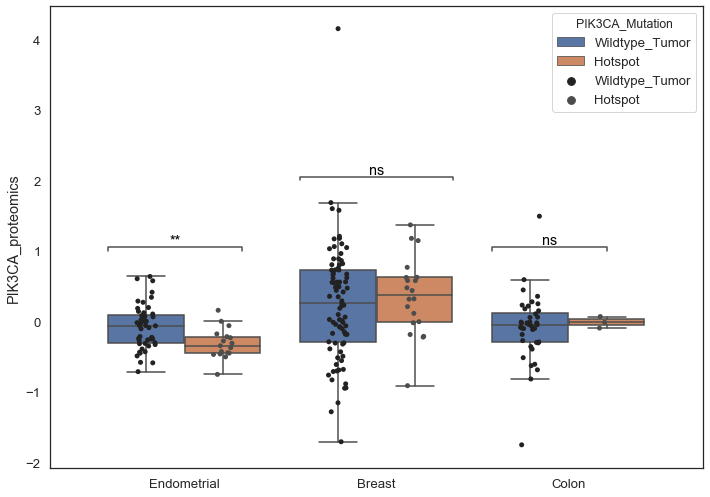

In [15]:
# pancancer cis plot
gene = 'PIK3CA_proteomics'
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2, style = "white")

boxplot = sns.boxplot(x='cancer', y=gene, data = df, hue = 'PIK3CA_Mutation',
                      hue_order = ["Wildtype_Tumor", "Hotspot"], showfliers = False)    
boxplot = sns.stripplot(x='cancer', y=gene, data = df, jitter = True, 
                           color = ".3", hue = 'PIK3CA_Mutation', hue_order = ["Wildtype_Tumor", "Hotspot"], dodge = True)
boxplot.set(xlabel = "", ylabel = gene)
cancer_list = [ endo_pval, brca_pval, colon_pval]
# create pval annotations
symbols = {}
i = 0
for cancer_df in cancer_list:

    pval = float(cancer_df['P_Value'])
    cancer_names = ["En","Brca","Colon"]
    cancer = cancer_names [i]
    if pval  <= 0.001:
         symbols[cancer] = '***'
    elif pval  <= 0.01:
        symbols[cancer] = '**'  
    elif pval <= 0.05:
        symbols[cancer] = '*'
    else:
        symbols[cancer] = 'ns'
    i += 1
format_pval_annotation(symbols['En'], -.4, 0.3, 1) # Endometrial
format_pval_annotation(symbols['Brca'], .6, 1.4, 2) # Brca
format_pval_annotation(symbols['Colon'], 1.6, 2.2, 1)  # Colon


plt.show()
plt.clf()
plt.close()

In [16]:
fig = boxplot.get_figure()
fig.savefig("PIK3CA_Fig2A.png", dpi = 300)